# Multi-layer Perceptron Model

> you must run the data-science.ipynb first in order to get the experimental model

# Import packages

In [1]:
# load data
# Add directory above current directory to path
import sys; sys.path.insert(0, '..')
from submodules.load_data import load_data

# data manipulation
import numpy as np
import pandas as pd

# data splitting
from sklearn.model_selection import train_test_split

# data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# model
from sklearn.neural_network import MLPClassifier

# hyperparameter tuning
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

# k-fold cross validation
from sklearn.model_selection import cross_validate

# saving models
import joblib

# performance
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt


# Load the data

Load semi-colon separated data from disk

In [2]:
#data = load_data()

csv_path = "../data/raw/dataSepsis.csv"
data = pd.read_csv(csv_path, sep=";")

# Create a Test Dataset

In [3]:
X_train, X_test, y_train, y_test = \
    train_test_split(data.drop(["Age", "Unit1", "Unit2", "HospAdmTime", "ICULOS", "Gender", "isSepsis"], axis=1),
    data["isSepsis"], test_size=0.2,
    random_state=42, stratify=data["isSepsis"])

# Transformation pipeline

In [4]:
pipeline = joblib.load("../data/transform/pipeline_minmax.pkl")

# Transform the data

In [5]:
X_train_prepared = pipeline.fit_transform(X_train)

# Load the model

In [6]:
# load the model from disk
model = joblib.load("../models/experiment/mlp_model.pkl")

# Fine tune the Random Forest Classifier with Randomize Search Cross Validation

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html?highlight=randomizedsearchcv#sklearn.model_selection.RandomizedSearchCV
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [7]:
print("[INFO] setting hyperparameters...")
hidden_layer_sizes = [5, 10, 20, 50, 100, (50,50,50,50)]
activation = ["relu", "logistic", "tanh"]
solver = ["lbfgs", "sgd", "adam"]
learning_rate = ["constant", "invscaling", "adaptive"]
max_iter = [500, 1000, 1500, 2500, 4000, 5000, 7000]
grid = dict(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, learning_rate=learning_rate, max_iter=max_iter)

[INFO] setting hyperparameters...


In [8]:
# initialize a cross-validation fold and perform a randomized-search
# to tune the hyperparameters
print("[INFO] grid searching over the hyperparameters...")
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
randomSearch = RandomizedSearchCV(estimator=model, n_jobs=-1,
	cv=cvFold, param_distributions=grid,
	scoring="f1", return_train_score=True)
X_train = pipeline.fit_transform(X_train)
searchResults = randomSearch.fit(X_train_prepared, y_train)

[INFO] grid searching over the hyperparameters...


In [9]:
# print the best score
searchResults.best_score_

0.40872269108352677

In [10]:
# print the best combination of parameters
searchResults.best_params_

{'solver': 'adam',
 'max_iter': 7000,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': 100,
 'activation': 'relu'}

In [11]:
# print the best estimator directly
searchResults.best_estimator_

MLPClassifier(hidden_layer_sizes=100, learning_rate='adaptive', max_iter=7000)

MLP Confusion Matrix
[[26739   184]
 [ 1476   642]]


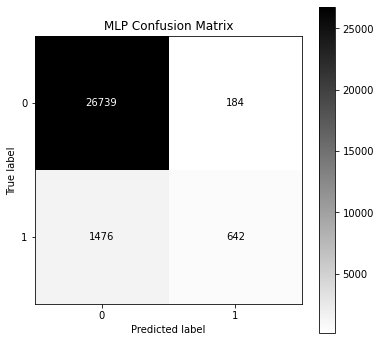

In [12]:
# confusion matrix with best_estimator_
title = "MLP Confusion Matrix"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_confusion_matrix(searchResults.best_estimator_, X_train_prepared, y_train, cmap="binary", ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.savefig("../reports/figures/tune/mlp_cm.png")

# Serialize the Model

In [13]:
# serialize the model
joblib.dump(searchResults.best_estimator_, "../models/tune/mlp_model.pkl", compress=('bz2', 3))

['../models/tune/mlp_model.pkl']

# Load the model

In [14]:
# load the model from disk
model = joblib.load("../models/tune/mlp_model.pkl")

# Test the Model

In [15]:
X_test_prepared = pipeline.transform(X_test)

#### Confusion Matrix

MLP Confusion Matrix
[[6673   59]
 [ 399  130]]


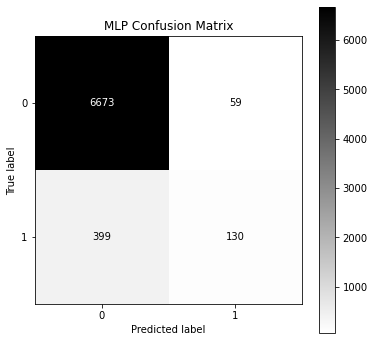

In [16]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

title = "MLP Confusion Matrix"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_confusion_matrix(model, X_test_prepared, y_test, cmap="binary", ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.savefig("../reports/figures/final/mlp_cm.png")

#### Precision Recall Curve

MLP Precision Recall Curve
0.4477384302229575


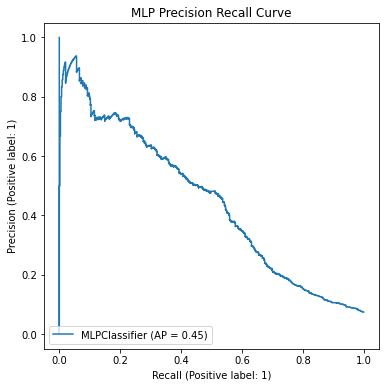

In [17]:
# computes a precision-recall curve from the ground truth label and a score given
# by the classifier by varying a decision threshold
title = "MLP Precision Recall Curve"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_precision_recall_curve(model, X_test_prepared, y_test, ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.average_precision)
#disp.ax_.set_title('Precision-Recall curve')
plt.savefig("../reports/figures/final/mlp_prc.png")

In [18]:
# serialize the model
joblib.dump(model, "../models/final/mlp_model.pkl", compress=('bz2', 3))

['../models/final/mlp_model.pkl']